# Dynamic VGC Parameter Fitting

In [3]:
current_gridsearch_file = "./dvgc-gridsearch/results/gridsearch.json"
mean_obstacle_data_file = "./dvgc-gridsearch/mean_obstacle_data.json"
fit_params = [
    'wall_bias',
    'wall_bump_cost',
    'ground_policy_inv_temp',
    'ground_policy_rand_choose',
    'switching_inv_temp',
    'switching_rand_choose',
]
exp_dvs = [
    'exp1-attention_N',
    'exp2-attention_N',
    'exp3-correct',
    'exp3-conf_N',
    'exp3-attention_N',
    'exp4a-hovered',
    'exp4a-log_hoverduration',
    'exp4b-hovered',
    'exp4b-log_hoverduration'
]
exp_names = {
    'exp1': "Initial Exp",
    'exp2': "Up-Front Planning Exp",
    'exp3': "Critical Maze Exp",
    'exp4a': "Process-Tracing (Initial Mazes)",
    'exp4b': "Process-Tracing (Critical Mazes)",
}
dv_names = {
    'attention_N': "Awareness",
    'correct': "Accuracy",
    'conf_N': "Confidence",
    'hovered': "Hovering",
    'log_hoverduration': "Duration",
}
exp_dvs_names = {
    'exp1-attention_N': "Initial Exp\nAwareness Judgment",
    'exp2-attention_N': "Up-Front Planning Exp\nAwareness Judgment",
    'exp3-correct': "Critical Maze Exp\nRecall Accuracy",
    'exp3-conf_N': "Critical Maze Exp\nRecall Confidence",
    'exp3-attention_N': "Critical Maze Exp\nAwareness Judgment",
    'exp4a-hovered': "Process-Tracing\n(Initial Mazes)\nHovering",
    'exp4a-log_hoverduration': "Process-Tracing\n(Initial Mazes)\nLog-Hover Duration",
    'exp4b-hovered': "Process-Tracing\n(Critical Mazes)\nHovering",
    'exp4b-log_hoverduration': "Process-Tracing\n(Critical Mazes)\nLog-Hover Duration",
}
param_names_to_latex = {
    'wall_bias': r"$r_{\text{edge}}$",
    'wall_bump_cost': r"$r_{\text{bump}}$",
    'ground_policy_inv_temp': r"$\alpha_a^{-1}$",
    'ground_policy_rand_choose': r"$\epsilon_a$",
    'switching_inv_temp': r"$\alpha_c^{-1}$",
    'switching_rand_choose': r"$\epsilon_c$",
}
exp_dv_ylims = {
    'exp1-attention_N': (.1, .9),
    'exp2-attention_N': (.1, .9),
    'exp3-correct': (.4, 1.0),
    'exp3-conf_N': (.35, .9),
    'exp3-attention_N': (.1, .9),
    'exp4a-hovered': (0, 1.0),
    # 'exp4a-log_hoverduration': None,
    'exp4b-hovered': (0, 1.0),
    # 'exp4b-log_hoverduration': None,
}

In [4]:
import textwrap
import json
from frozendict import frozendict
from types import SimpleNamespace
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from functools import lru_cache
matplotlib.rcParams['pdf.fonttype'] = 42

font = {
    'family' : 'Arial',
    'size'   : 7
}
matplotlib.rc('font', **font)

def coeff_of_determination(model_vals, exp_vals):
    """Returns R2 when fitting an intercept and slope"""
    return stats.linregress(model_vals, exp_vals).rvalue**2

@lru_cache()
def get_mean_obstacle_data():
    mean_obstacle_data = json.load(open(mean_obstacle_data_file, 'r'))
    mean_obstacle_data_df = []
    for exp, data in mean_obstacle_data.items():
        df = pd.DataFrame(data)
        df = df.set_index(['grid', 'obstacle'])
        df.columns = [f"{exp.split('_')[0]}-{c}" for c in df.columns]
        mean_obstacle_data_df.append(df)
    mean_obstacle_data_df = pd.concat(mean_obstacle_data_df, axis=1)
    return mean_obstacle_data_df

def calculate_data_r2(dvgc_preds):
    mean_obstacle_data_df = get_mean_obstacle_data()
    dvgc_data_df = pd.merge(
        dvgc_preds[['grid', 'obstacle', 'dvgc_occ_prob']],
        mean_obstacle_data_df,
        on=['grid', 'obstacle']
    )
    exp_dv_r2 = {}
    for exp_dv in mean_obstacle_data_df.columns:
        model_resp = [
            (m, v) for m, v in dvgc_data_df[['dvgc_occ_prob', exp_dv]].values 
            if not np.isnan(v)
        ]
        model_vals, exp_vals = zip(*model_resp)
        r2 = coeff_of_determination(model_vals, exp_vals)
        exp_dv_r2[f"{exp_dv}"] = r2
    return pd.Series(exp_dv_r2)

In [5]:
@lru_cache()
def get_gridsearch_results(gridsearch_file):
    return pd.DataFrame(json.load(open(gridsearch_file, "r")))
    
@lru_cache()
def get_parameter_fits(
    gridsearch_file,
    fixed_param_values=None,
):
    gridsearch = get_gridsearch_results(gridsearch_file)
    if fixed_param_values is not None:
        gridsearch = gridsearch.merge(pd.DataFrame([fixed_param_values]), how="inner")
    param_r2_df = gridsearch.groupby(fit_params).apply(calculate_data_r2)
    return param_r2_df

def calc_best_parameters(
    gridsearch_file,
    fixed_param_values=None
):
    param_r2_df = get_parameter_fits(
        gridsearch_file,
        fixed_param_values=fixed_param_values
    )

    # get best parameter combination for each experiment
    param_max = param_r2_df.idxmax().to_dict()
    param_max = {
        exp_dv: dict(zip(param_r2_df.index.names, params)) 
        for exp_dv, params in param_max.items()
    }
    exp_dvs = sorted(param_max.keys())
    
    # get the model predictions and mean obstacle responses for each exp
    gridsearch = get_gridsearch_results(gridsearch_file)
    mean_obstacle_data_df = get_mean_obstacle_data()
    data_max = {}
    r2_max = {}
    for exp_dv in exp_dvs:
        dvgc_preds = pd.merge(pd.DataFrame([param_max[exp_dv]]), gridsearch)[["grid", "obstacle", "dvgc_occ_prob"]]
        dvgc_preds_exp_dv = dvgc_preds.merge(
            mean_obstacle_data_df[exp_dv].dropna().reset_index(),
            how="inner"
        )
        data_max[exp_dv] = dvgc_preds_exp_dv
        r2_max[exp_dv] = stats.linregress(dvgc_preds_exp_dv["dvgc_occ_prob"], dvgc_preds_exp_dv[exp_dv]).rvalue**2
    
    return SimpleNamespace(
        param_max=param_max,
        data_max=data_max,
        r2_max=r2_max
    )

In [6]:
def plot_parameter_result_scatterplots(
    best_params,
    exp_dv_xlims=None,
    exp_dv_ylims=None,
    nrows=3,
    ncols=3,
    figsize=(5, 6),
    dpi=300,
    xlabel="Fitted VGC Prob"
):
    if exp_dv_xlims is None:
        exp_dv_xlims = {}
    if exp_dv_ylims is None:
        exp_dv_ylims = {}
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=dpi)
    axes = list(axes.flatten())
    for exp_dv in exp_dvs:
        ax = axes.pop(0)
        model_exp_dv_df = best_params.data_max[exp_dv]
        model_vals, exp_vals = model_exp_dv_df['dvgc_occ_prob'], model_exp_dv_df[exp_dv]
        ax.plot(
            model_vals, exp_vals,
            linestyle='',
            marker="x",
            markerfacecolor="none",
            markersize=3,
            markeredgewidth=.5,
            markeredgecolor="black",
            rasterized=False,
        )
        if exp_dv in exp_dv_xlims:
            ax.set_xlim(*exp_dv_xlims[exp_dv])
        if exp_dv in exp_dv_ylims:
            ax.set_ylim(*exp_dv_ylims[exp_dv])
        linreg = stats.linregress(model_vals, exp_vals)
        xlim = np.array(ax.get_xlim())
        ylim = np.array(ax.get_ylim())
        ax.plot(xlim, linreg.intercept + linreg.slope*xlim, 
                color='maroon', linestyle='--', lw=.5)
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.text(
            xlim[1], ylim[0], 
            f'$R^2={linreg.rvalue**2:.2f}$ ',
            ha='right', va='bottom',
            color='maroon', fontsize=7
        )
        param_max = best_params.param_max[exp_dv]
        # title = exp_dvs_names[exp_dv]
        # title += "\n"+"\n".join([f"{p}={v:.2f}" for p, v in param_max.items()])
        # ax.set_title(
        #     title,
        #     fontsize=7
        # )
        ax.set_ylabel(exp_dvs_names[exp_dv])
        ax.set_xlabel(xlabel)
    while axes:
        axes.pop(0).remove()
    return fig

In [7]:
def calc_r2(exp_dv, best_params_res):
    model_exp_dv_df = best_params_res.data_max[exp_dv]
    model_vals, exp_vals = model_exp_dv_df['dvgc_occ_prob'], model_exp_dv_df[exp_dv]
    linreg = stats.linregress(model_vals, exp_vals)
    r2 = linreg.rvalue**2
    return r2


## Fit results for only inverse temp and random choice

Fitted DVGC plot saved to  ./figures/fitted_vgc_scatter.pdf


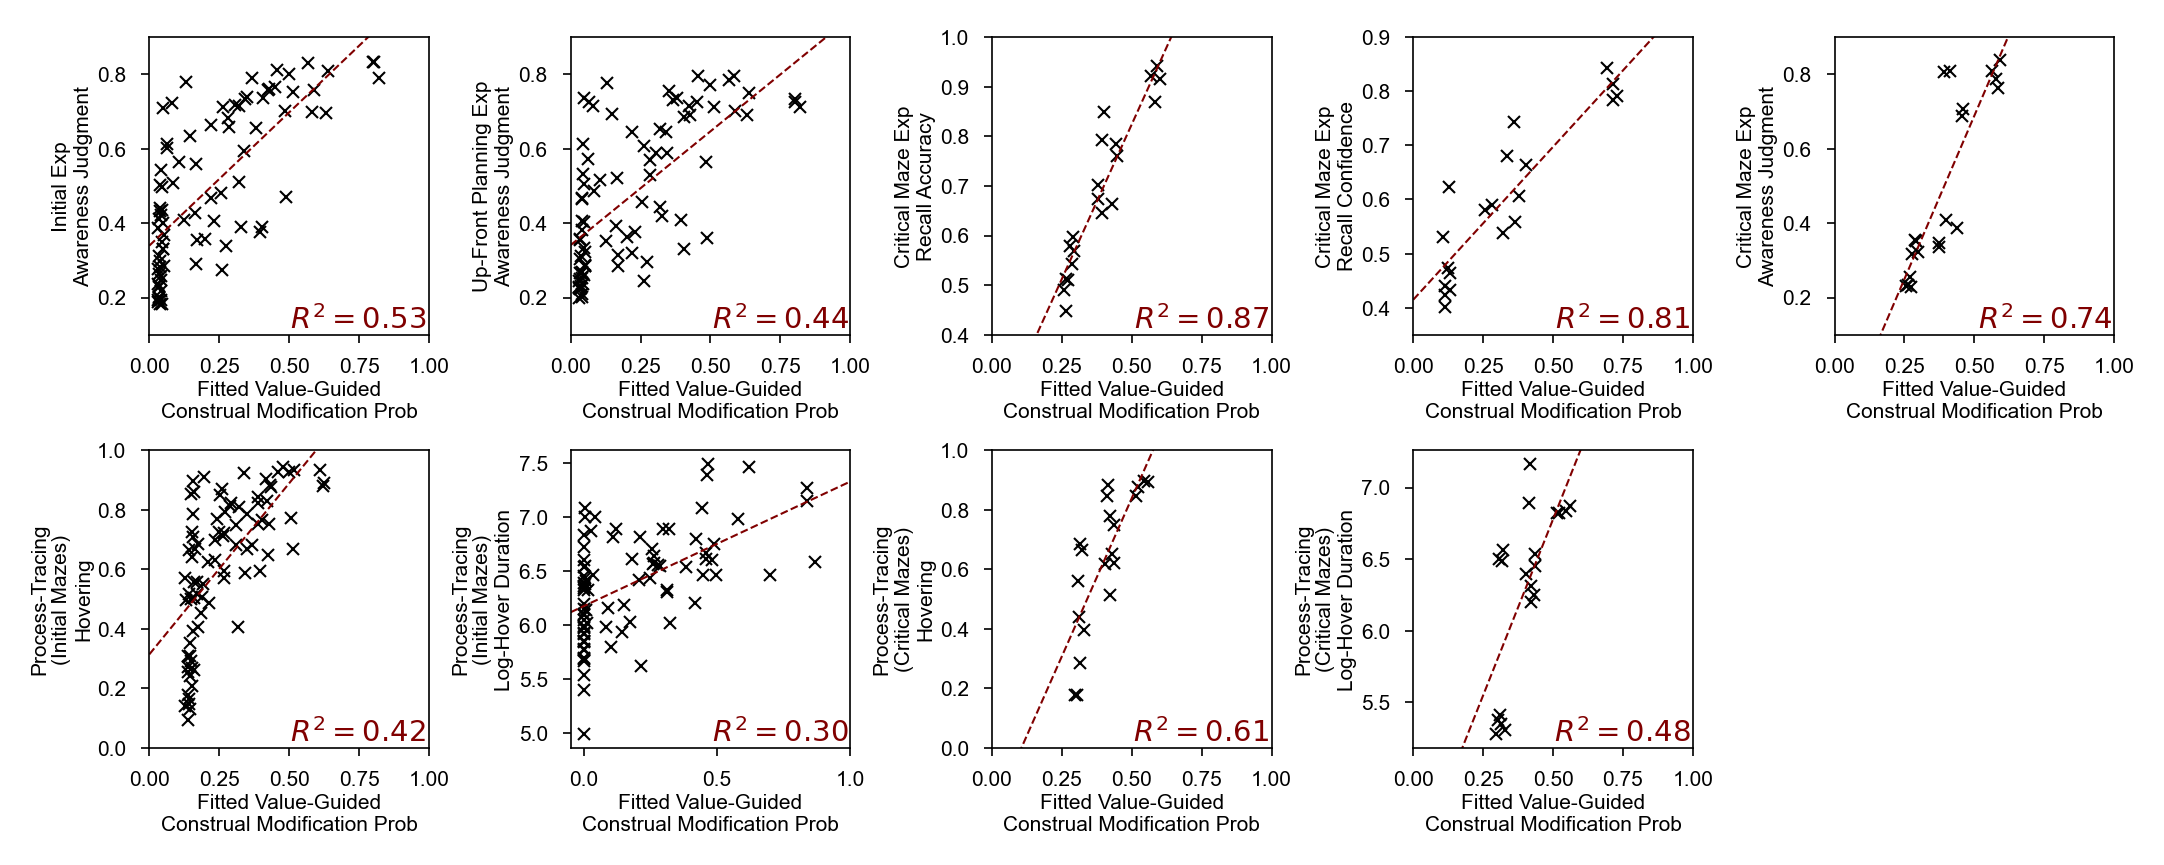

In [8]:
import matplotlib
matplotlib.rcParams['font.family'] = "Arial"
matplotlib.rcParams['font.size'] = 5
matplotlib.rcParams['axes.linewidth'] = .4
matplotlib.rcParams['xtick.major.size'] = 2
matplotlib.rcParams['xtick.major.width'] = .4
matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['ytick.major.width'] = .4
matplotlib.rcParams['axes.labelsize'] = 5
matplotlib.rcParams['axes.labelpad'] = 1

fig_width_mm = 182
fig_height_mm = 72
# fig_width_mm = 89
# fig_height_mm = 200

mm_to_inch = 1/25.4 
figsize = (fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch)
assert fig_width_mm <= 182
assert fig_height_mm <= 245

best_parameters_no_aux = calc_best_parameters(
    current_gridsearch_file,
    fixed_param_values=frozendict({"wall_bias": 0., "wall_bump_cost": 0.}),
)
no_aux_fig = plot_parameter_result_scatterplots(
    best_parameters_no_aux,
    exp_dv_xlims={
        'exp1-attention_N': (0, 1),
        'exp2-attention_N': (0, 1),
        'exp3-correct': (.0, 1),
        'exp3-conf_N': (0, 1),
        'exp3-attention_N': (.0, 1),
        'exp4a-hovered': (.0, 1),
        'exp4a-log_hoverduration': (-.05, 1.0),
        'exp4b-hovered': (.0, 1),
        'exp4b-log_hoverduration': (.0, 1),
    },
    exp_dv_ylims=exp_dv_ylims,
    figsize=figsize,
    ncols=5,
    nrows=2,
    dpi=300,
    xlabel="Fitted Value-Guided\nConstrual Modification Prob"
)
# _ = no_aux_fig.suptitle(r"Fit Parameters: $\alpha_{a}$, $\epsilon_a$, $\alpha_{c}$, $\epsilon_{c}$ (Fitted version)", fontsize=6)
plt.tight_layout(h_pad=1, w_pad=.1)
fitted_dvgc_file = "./figures/fitted_vgc_scatter.pdf"
no_aux_fig.savefig(
    fitted_dvgc_file,
    dpi=300,
)
print("Fitted DVGC plot saved to ", fitted_dvgc_file)

In [9]:
# Table with parameters for two fits
noaux_params_df = pd.DataFrame(best_parameters_no_aux.param_max).\
    drop(['wall_bias', 'wall_bump_cost'], axis=0).\
    rename(index=param_names_to_latex).T
    # reset_index().T
    # set_index(["param_set", "index"]).T
# noaux_params_df[("Fit Without Policy Biases", r'$R^2$')] = \
#     [np.round(calc_r2(exp_dv, best_parameters_no_aux), 2) for exp_dv in noaux_params_df.index]
noaux_params_df[r'$R^2$'] = \
    [np.round(calc_r2(exp_dv, best_parameters_no_aux), 2) for exp_dv in noaux_params_df.index]
# noaux_params_df.columns.names = [None, None]
noaux_params_df['exp'] = [i.split('-')[0] for i in noaux_params_df.index]
noaux_params_df['exp'] = noaux_params_df['exp'].apply(lambda n: exp_names[n])
noaux_params_df['dv'] = [i.split('-')[1] for i in noaux_params_df.index]
noaux_params_df['dv'] = noaux_params_df['dv'].apply(lambda n: dv_names[n])
noaux_params_df = noaux_params_df.set_index(["exp", "dv"], drop=True)
noaux_params_df.index.names = [None, None]

noaux_params_df_tex = noaux_params_df.to_latex(
    float_format="{:0.2f}".format,
    escape=False,
    column_format='llccccc'
)
with open("./inputs/fitted_dvgc_param_table.tex", "w") as file:
    file.write(noaux_params_df_tex)
print(noaux_params_df_tex)
noaux_params_df.round(2)

\begin{tabular}{llccccc}
\toprule
                                 &          &  $\alpha_a^{-1}$ &  $\epsilon_a$ &  $\alpha_c^{-1}$ &  $\epsilon_c$ &  $R^2$ \\
\midrule
Initial Exp & Awareness &             1.00 &          0.20 &             5.00 &          0.05 &   0.53 \\
Up-Front Planning Exp & Awareness &             1.00 &          0.20 &             5.00 &          0.05 &   0.44 \\
Critical Maze Exp & Awareness &             3.00 &          0.10 &             1.00 &          0.05 &   0.74 \\
                                 & Accuracy &             3.00 &          0.20 &             1.00 &          0.05 &   0.87 \\
                                 & Confidence &             5.00 &          0.00 &             9.00 &          0.20 &   0.81 \\
Process-Tracing (Initial Mazes) & Duration &             1.00 &          0.00 &             9.00 &          0.00 &   0.30 \\
                                 & Hovering &             7.00 &          0.20 &             7.00 &          0.30 &   

$\alpha_a^{-1}$  $\epsilon_a$  \
Initial Exp                      Awareness               1.0           0.2   
Up-Front Planning Exp            Awareness               1.0           0.2   
Critical Maze Exp                Awareness               3.0           0.1   
                                 Accuracy                3.0           0.2   
                                 Confidence              5.0           0.0   
Process-Tracing (Initial Mazes)  Duration                1.0           0.0   
                                 Hovering                7.0           0.2   
Process-Tracing (Critical Mazes) Duration                5.0           0.1   
                                 Hovering                5.0           0.1   

                                             $\alpha_c^{-1}$  $\epsilon_c$  \
Initial Exp                      Awareness               5.0          0.05   
Up-Front Planning Exp            Awareness               5.0          0.05   
Critical Maze Exp                Awareness               1.0          0.05   
                                 Accuracy                1.0          0.05   
                                 Confidence              9.0          0.20   
Process-Tracing (Initial Mazes)  Duration                9.0          0.00   
                                 Hovering                7.0          0.30   
Process-Tracing (Critical Mazes) Duration                1.0          0.30   
                                 Hovering                1.0          0.30   

                                             $R^2$  
Initial Exp                      Awareness    0.53  
Up-Front Planning Exp            Awareness    0.44  
Critical Maze Exp                Awareness    0.74  
                                 Accuracy     0.87  
                                 Confidence   0.81  
Process-Tracing (Initial Mazes)  Duration     0.30  
                                 Hovering     0.42  
Process-Tracing (Critical Mazes) Duration     0.48  
                                 Hovering     0.61

## Fit results for wall bias and wall bump cost

Fitted DVGC with policy bias plot saved to  ./inputs/fitted_policy_bias_dvgc_scatter.pdf


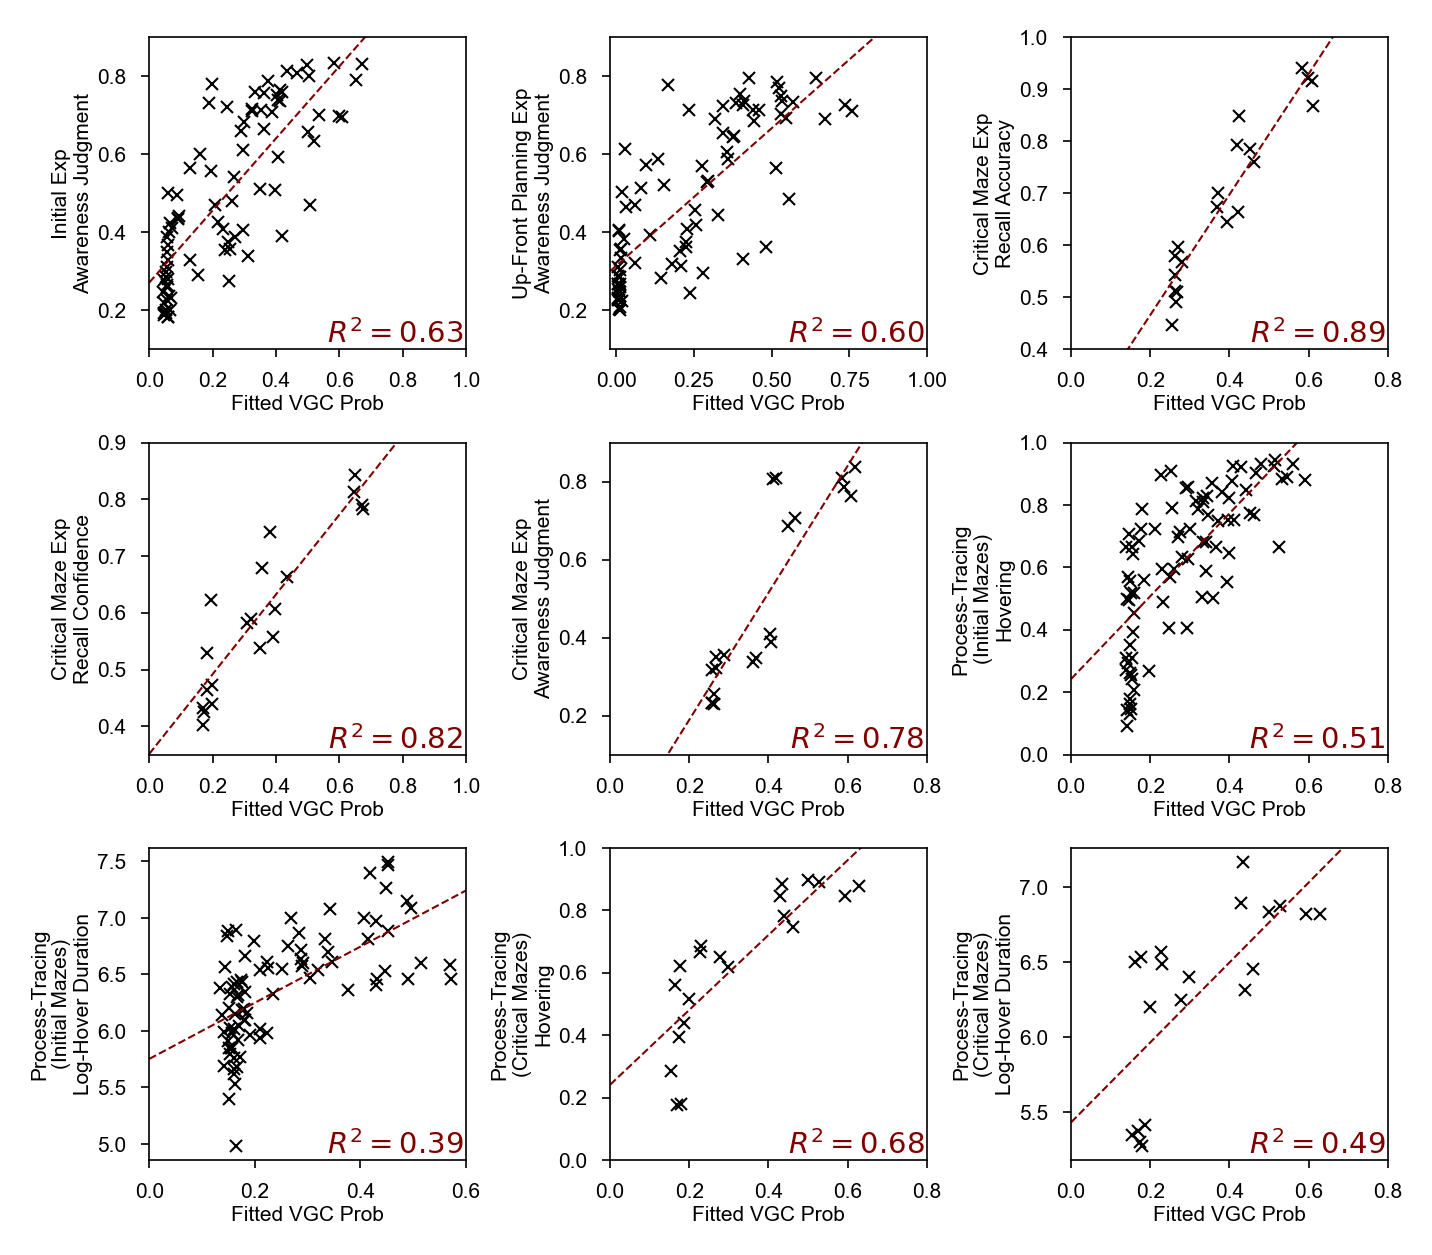

In [10]:
matplotlib.rcParams['font.family'] = "Arial"
matplotlib.rcParams['font.size'] = 5
matplotlib.rcParams['axes.linewidth'] = .4
matplotlib.rcParams['xtick.major.size'] = 2
matplotlib.rcParams['xtick.major.width'] = .4
matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['ytick.major.width'] = .4
matplotlib.rcParams['axes.labelsize'] = 5
matplotlib.rcParams['axes.labelpad'] = 1

fig_width_mm = 120
fig_height_mm = 105

mm_to_inch = 1/25.4 
figsize = (fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch)
assert fig_width_mm <= 182
assert fig_height_mm <= 245


best_parameters = calc_best_parameters(
    current_gridsearch_file,
    fixed_param_values=None,
)
all_params_fig = plot_parameter_result_scatterplots(
    best_parameters,
    exp_dv_xlims={
        'exp1-attention_N': (0, 1),
        'exp2-attention_N': (-0.02, 1),
        'exp3-correct': (.0, .8),
        'exp3-conf_N': (0, 1.0),
        'exp3-attention_N': (.0, .8),
        'exp4a-hovered': (.0, .8),
        'exp4a-log_hoverduration': (0, .6),
        'exp4b-hovered': (0, .8),
        'exp4b-log_hoverduration': (0, .8),
    },
    exp_dv_ylims=exp_dv_ylims,
    figsize=figsize,
    ncols=3,
    nrows=3,
    dpi=300
)
# _ = all_params_fig.suptitle(r"Fit Parameters: $\alpha_{a}$, $\epsilon_a$, $\alpha_{c}$, $\epsilon_{c}$, $r_{edge}$, $r_{bump}$ (Fitted + Policy Bias version)")
plt.tight_layout(h_pad=1., w_pad=.5)
fitted_policy_bias_dvgc_file = "./inputs/fitted_policy_bias_dvgc_scatter.pdf"
all_params_fig.savefig(
    fitted_policy_bias_dvgc_file,
    dpi=300,
)
print("Fitted DVGC with policy bias plot saved to ", fitted_policy_bias_dvgc_file)

In [11]:
# Table with parameters for two fits
all_params_df = pd.DataFrame(best_parameters.param_max)
all_params_df.loc['wall_bias'] = [-v if v > 0 else v for v in all_params_df.loc['wall_bias']] #flip this for the paper for clarity
all_params_df = all_params_df\
    .loc[['ground_policy_inv_temp', # reorder params
      'ground_policy_rand_choose',
      'switching_inv_temp',
      'switching_rand_choose',
      'wall_bias',
      'wall_bump_cost', 
     ]].\
    rename(index=param_names_to_latex).T
all_params_df[r'$R^2$'] = \
    [np.round(calc_r2(exp_dv, best_parameters), 2) for exp_dv in all_params_df.index]
# all_params_df.columns.names = [None, None]
all_params_df['exp'] = [i.split('-')[0] for i in all_params_df.index]
all_params_df['exp'] = all_params_df['exp'].apply(lambda n: exp_names[n])
all_params_df['dv'] = [i.split('-')[1] for i in all_params_df.index]
all_params_df['dv'] = all_params_df['dv'].apply(lambda n: dv_names[n])
all_params_df = all_params_df.set_index(["exp", "dv"], drop=True)
all_params_df.index.names = [None, None]

all_params_df_tex = all_params_df.to_latex(
    float_format="{:0.2f}".format,
    escape=False,
    column_format='llccccccc'
)
with open("./inputs/fitted_dvgc_bias_param_table.tex", "w") as file:
    file.write(all_params_df_tex)
print(all_params_df_tex)
all_params_df.round(2)

\begin{tabular}{llccccccc}
\toprule
                                 &          &  $\alpha_a^{-1}$ &  $\epsilon_a$ &  $\alpha_c^{-1}$ &  $\epsilon_c$ &  $r_{\text{edge}}$ &  $r_{\text{bump}}$ &  $R^2$ \\
\midrule
Initial Exp & Awareness &             1.00 &          0.20 &             9.00 &          0.10 &              -0.10 &              -1.00 &   0.63 \\
Up-Front Planning Exp & Awareness &             1.00 &          0.20 &             5.00 &          0.00 &              -0.10 &              -1.00 &   0.60 \\
Critical Maze Exp & Awareness &             5.00 &          0.20 &             1.00 &          0.00 &               0.00 &              -1.00 &   0.78 \\
                                 & Accuracy &             3.00 &          0.10 &             1.00 &          0.00 &              -0.01 &              -1.00 &   0.89 \\
                                 & Confidence &             3.00 &          0.10 &             5.00 &          0.30 &               0.00 &              -1.00 &

$\alpha_a^{-1}$  $\epsilon_a$  \
Initial Exp                      Awareness               1.0           0.2   
Up-Front Planning Exp            Awareness               1.0           0.2   
Critical Maze Exp                Awareness               5.0           0.2   
                                 Accuracy                3.0           0.1   
                                 Confidence              3.0           0.1   
Process-Tracing (Initial Mazes)  Duration                1.0           0.2   
                                 Hovering                1.0           0.2   
Process-Tracing (Critical Mazes) Duration                1.0           0.0   
                                 Hovering                1.0           0.0   

                                             $\alpha_c^{-1}$  $\epsilon_c$  \
Initial Exp                      Awareness               9.0           0.1   
Up-Front Planning Exp            Awareness               5.0           0.0   
Critical Maze Exp                Awareness               1.0           0.0   
                                 Accuracy                1.0           0.0   
                                 Confidence              5.0           0.3   
Process-Tracing (Initial Mazes)  Duration                5.0           0.3   
                                 Hovering                5.0           0.3   
Process-Tracing (Critical Mazes) Duration                9.0           0.3   
                                 Hovering                9.0           0.3   

                                             $r_{\text{edge}}$  \
Initial Exp                      Awareness               -0.10   
Up-Front Planning Exp            Awareness               -0.10   
Critical Maze Exp                Awareness                0.00   
                                 Accuracy                -0.01   
                                 Confidence               0.00   
Process-Tracing (Initial Mazes)  Duration                -1.00   
                                 Hovering                -0.10   
Process-Tracing (Critical Mazes) Duration                -1.00   
                                 Hovering                -1.00   

                                             $r_{\text{bump}}$  $R^2$  
Initial Exp                      Awareness                -1.0   0.63  
Up-Front Planning Exp            Awareness                -1.0   0.60  
Critical Maze Exp                Awareness                -1.0   0.78  
                                 Accuracy                 -1.0   0.89  
                                 Confidence               -1.0   0.82  
Process-Tracing (Initial Mazes)  Duration                  0.0   0.39  
                                 Hovering                 -1.0   0.51  
Process-Tracing (Critical Mazes) Duration                 -0.1   0.49  
                                 Hovering                 -0.1   0.68

## Parameter Analyses

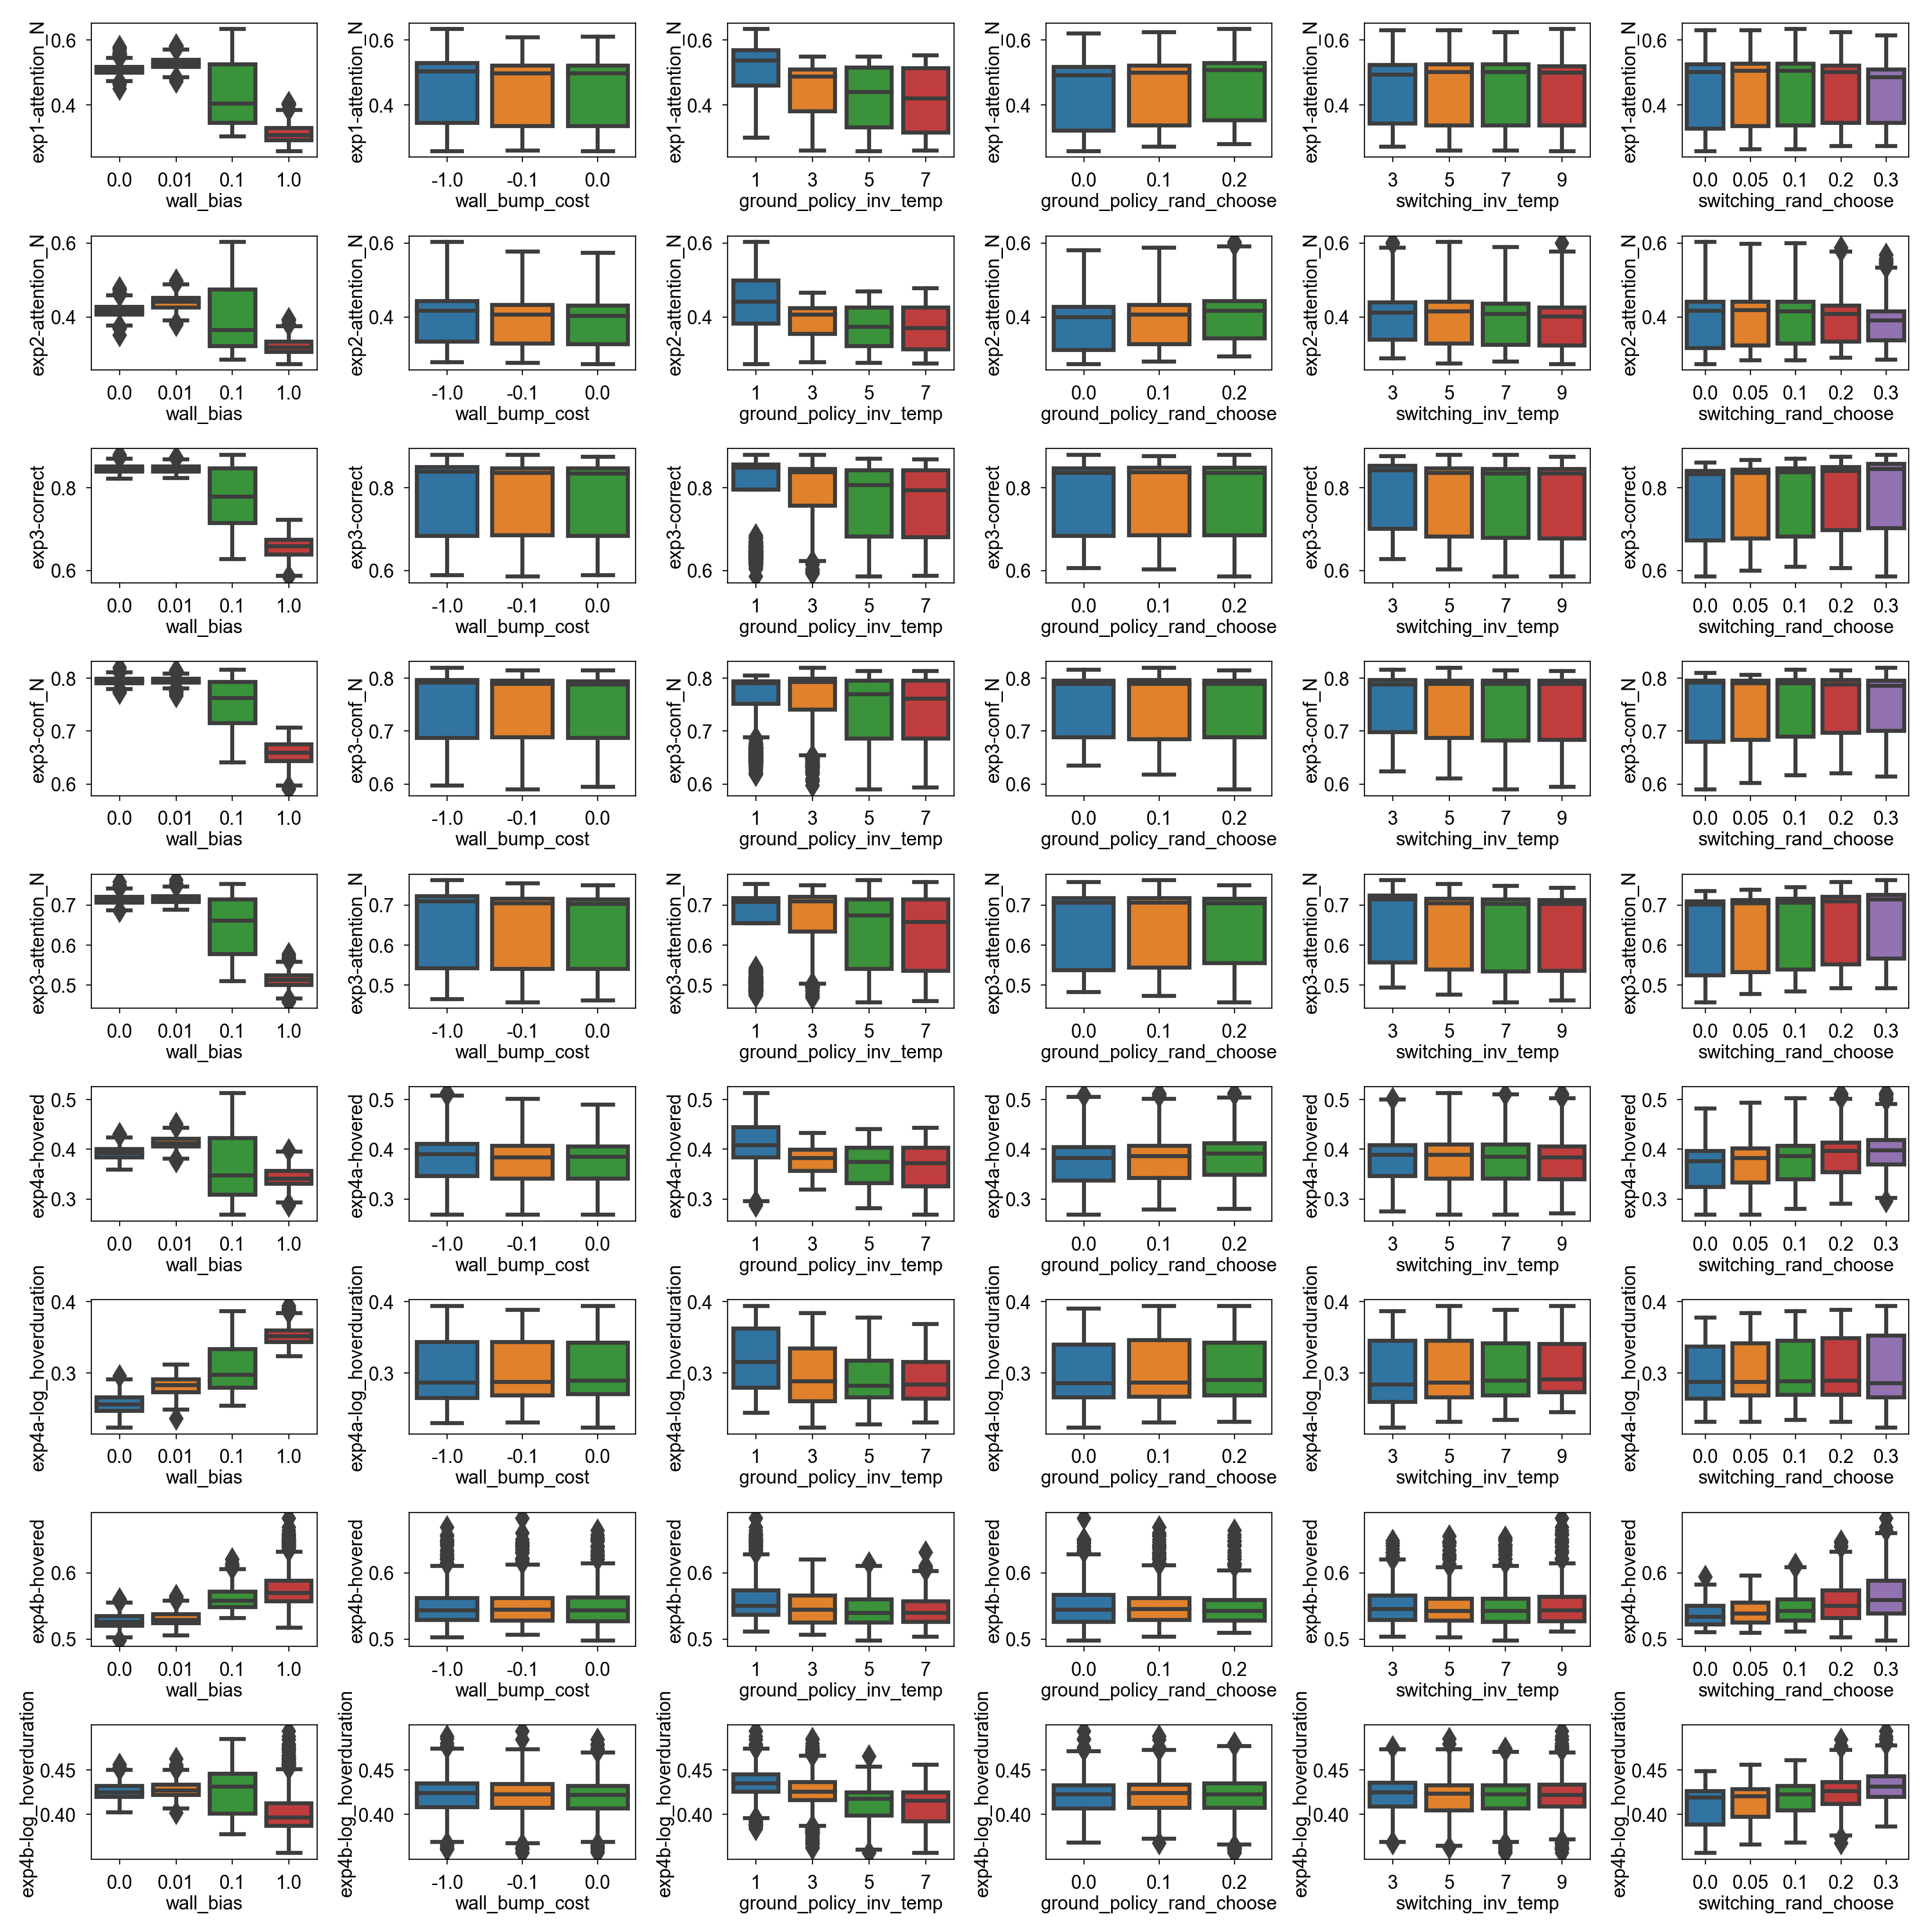

In [12]:
import matplotlib
matplotlib.rcParams['font.family'] = "Arial"
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['axes.linewidth'] = .4
matplotlib.rcParams['xtick.major.size'] = 2
matplotlib.rcParams['xtick.major.width'] = .4
matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['ytick.major.width'] = .4
matplotlib.rcParams['axes.labelsize'] = 7
matplotlib.rcParams['axes.labelpad'] = 1
matplotlib.rcParams['axes.titlesize'] = 7
matplotlib.rcParams['axes.labelpad'] = 1

to_plot = get_parameter_fits(
    current_gridsearch_file,
    fixed_param_values=None,
)
to_plot = to_plot.reset_index()
to_plot = to_plot[to_plot['switching_inv_temp'] > 1] # this is consistently bad
fig, axes = plt.subplots(nrows=len(exp_dvs), ncols=len(fit_params), figsize=(10, 10), dpi=300)
for ri, row in enumerate(axes):
    for ci, ax in enumerate(row):
        exp_dv = exp_dvs[ri]
        param_name = fit_params[ci]
        g = sns.boxplot(
            data=to_plot,
            x=param_name,
            y=exp_dv,
            # hue="switching_inv_temp",
            ax=ax
        )
plt.tight_layout()

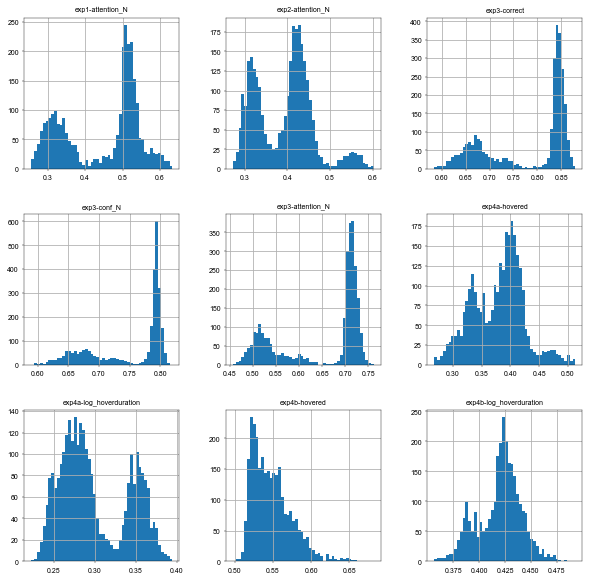

In [13]:
# R2 is consistent
_ = to_plot[exp_dvs].hist(figsize=(10, 10), bins=50)

# Comparison with other models ans static VGC

In [14]:
from prep_data import model_preds

In [15]:
vgc_models = ["static_vgc_weight", "dynamic_vgc_weight", "dvgc_occ_prob_nobias", "dvgc_occ_prob_fitbias"]
vgc_model_names = {
    "static_vgc_weight": "Single\nValue-Guided Construal\n(Fixed Params)",
    "dynamic_vgc_weight": "Value-Guided Construal\nModification\n(Fixed Params)",
    "dvgc_occ_prob_nobias": "Value-Guided Construal\nModification\n(Fitted Noise Params)",
    "dvgc_occ_prob_fitbias": "Value-Guided Construal\nModification\n(Fitted Noise + Plan Bias Params)"
}
def plot_vgc_models_exp_dvs(
    exp_dvs, vgc_models, best_parameters_no_aux, best_parameters,
    figsize=None,
    scatter_s=15,
    r2_fontsize=7,
    dpi=300
):
    nrows = len(exp_dvs)
    ncols = len(vgc_models)
    if figsize is None:
        figsize = (ncols*4.2, nrows*4)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi)

    for exp_dv_i, exp_dv in enumerate(exp_dvs):
        vgc_models_df = pd.merge(
            best_parameters_no_aux.data_max[exp_dv].rename(columns={"dvgc_occ_prob": "dvgc_occ_prob_nobias"}),
            best_parameters.data_max[exp_dv][["grid", "obstacle", "dvgc_occ_prob"]].\
                rename(columns={"dvgc_occ_prob": "dvgc_occ_prob_fitbias"}),
            on=["grid", "obstacle"],
        )
        vgc_models_df = pd.merge(
            vgc_models_df,
            model_preds[["grid", "obstacle", "dynamic_vgc_weight", "static_vgc_weight"]],
            on=["grid", "obstacle"]
        )
        vgc_models_df['vgc_binary'] = ["Rel" if svgc >= .1 else "Irrel" for svgc in vgc_models_df['static_vgc_weight']]

        for vgc_mod_i, vgc_mod in enumerate(vgc_models):
            if len(axes.shape) == 1:
                ax = axes[vgc_mod_i]
            else:
                ax = axes[exp_dv_i][vgc_mod_i]
            sns.scatterplot(
                data=vgc_models_df,
                x=vgc_mod,
                y=exp_dv,
                ax=ax,
                hue='vgc_binary',
                hue_order=["Irrel", "Rel"],
                palette=["grey", "mediumblue"],
                ec="w",
                s=scatter_s,
                alpha=.65
            )
            ax.set_xlim(-0.05, 1.05)
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.get_legend().remove()

            # linear regressions
            xlims = np.array(ax.get_xlim())
            ylims = np.array(ax.get_ylim())
            linreg = stats.linregress(vgc_models_df[vgc_mod], vgc_models_df[exp_dv])
            ax.plot(xlims, linreg.intercept + linreg.slope*xlims, color='maroon', linestyle='--', lw=1)
            ax.set_xlim(*xlims)
            ax.set_ylim(*ylims)
            ax.text(xlims[1], ylims[0], f"$R^2={linreg.rvalue**2:.2f}$  ", ha="right", va="bottom", color='maroon', fontsize=r2_fontsize)

    for exp_dv_i, exp_dv in enumerate(exp_dvs):
        if len(axes.shape) == 1:
            ax = axes[0]
        else:
            ax = axes[exp_dv_i][0]
        ax.set_ylabel(exp_dvs_names[exp_dv])
    for vgc_mod_i, vgc_mod in enumerate(vgc_models):
        if len(axes.shape) == 1:
            ax = axes[vgc_mod_i]
        else:
            ax = axes[0][vgc_mod_i]
        ax.set_title(vgc_model_names[vgc_mod])

    # plt.tight_layout(w_pad=.01, h_pad=.5)
    return fig

In [16]:
import matplotlib
matplotlib.rcParams['font.family'] = "Arial"
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['axes.linewidth'] = .4
matplotlib.rcParams['xtick.major.size'] = 2
matplotlib.rcParams['xtick.major.width'] = .4
matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['ytick.major.width'] = .4
matplotlib.rcParams['axes.labelsize'] = 7
matplotlib.rcParams['axes.labelpad'] = 1
matplotlib.rcParams['axes.titlesize'] = 7
matplotlib.rcParams['axes.labelpad'] = 1


VGC models by exp plot saved to  ./inputs/all_vgc_models_exp1_2.pdf


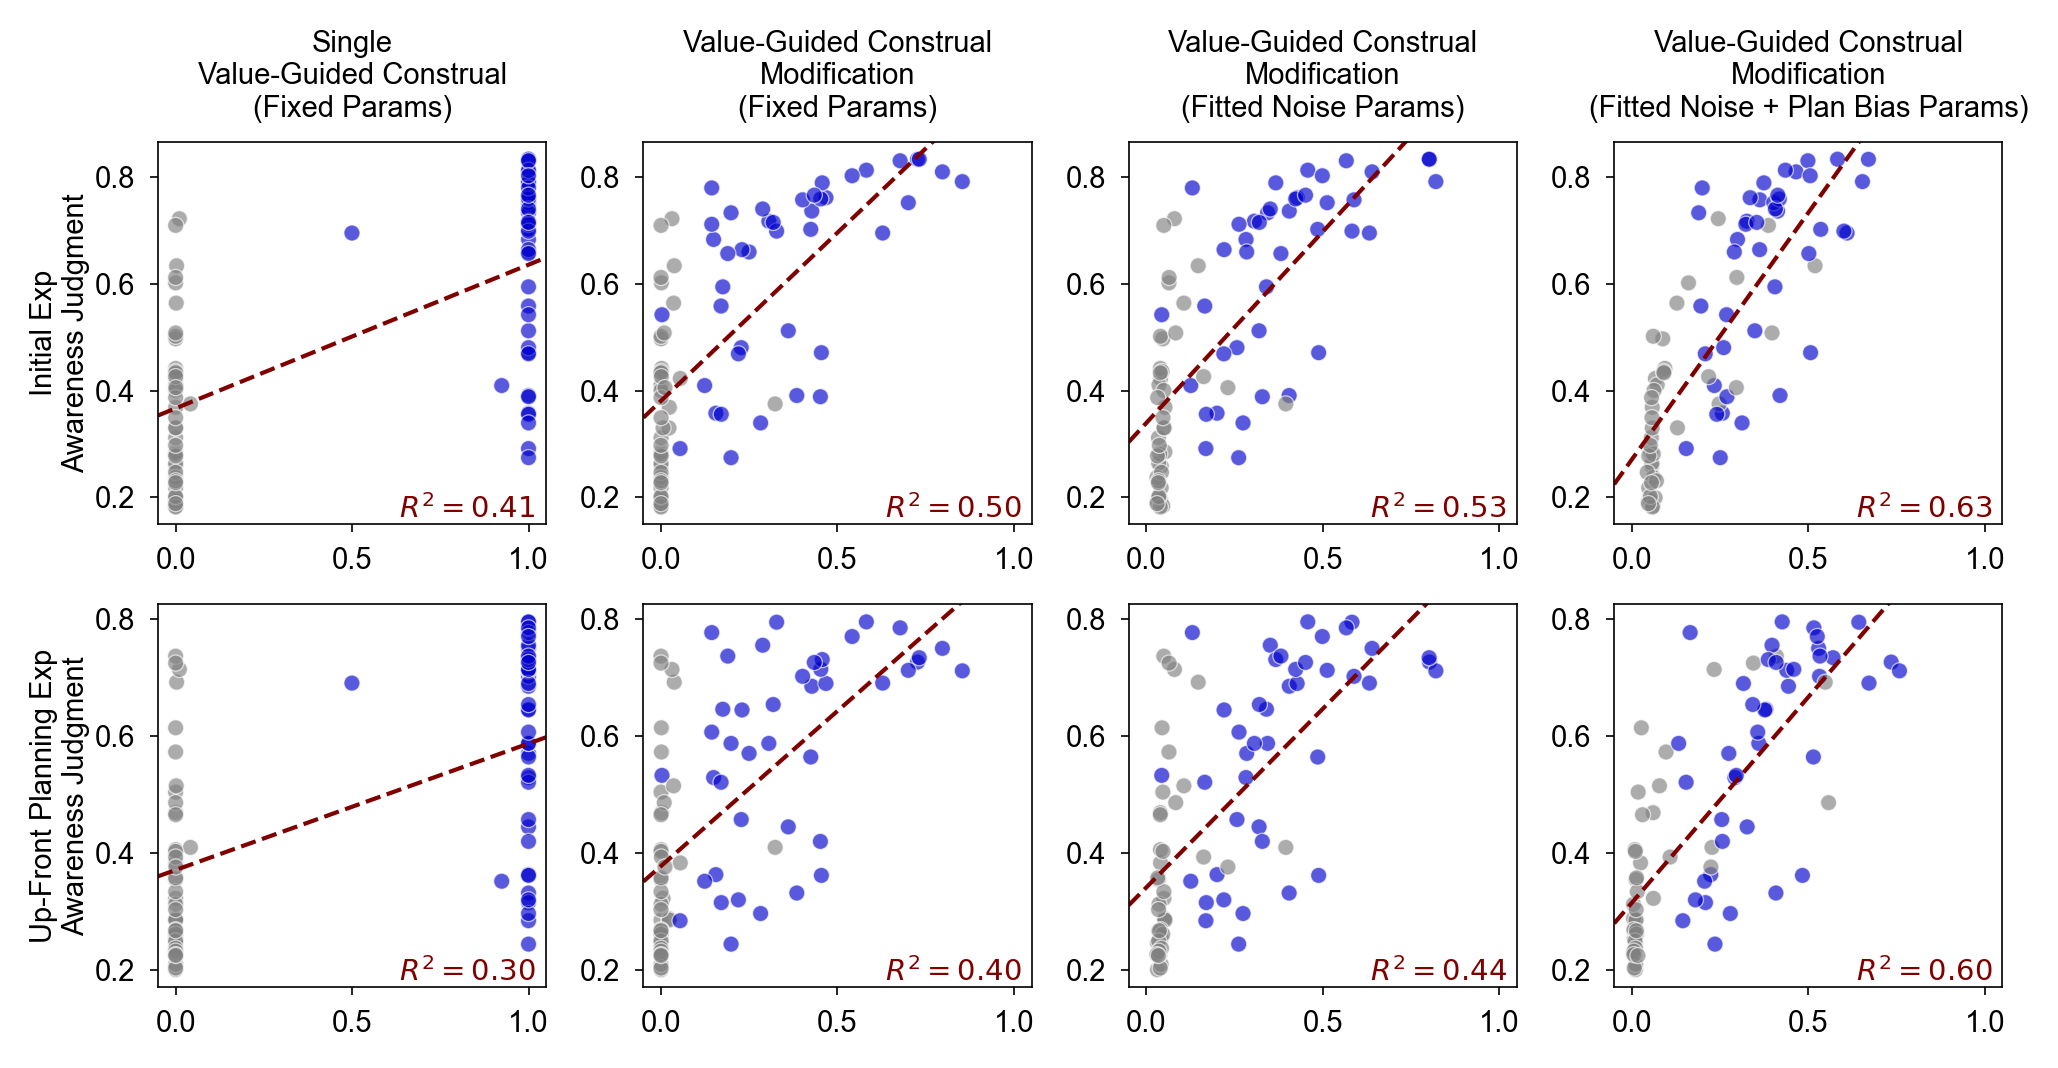

In [17]:
all_vgc_models_exp1_2_fig = plot_vgc_models_exp_dvs(
    exp_dvs[0:2], vgc_models, best_parameters_no_aux, best_parameters,
    figsize=(4*1.7, (2+.1)*1.7),
    dpi=300
)
plt.tight_layout(w_pad=1, h_pad=1)
all_vgc_models_exp1_2_file = "./inputs/all_vgc_models_exp1_2.pdf"
all_vgc_models_exp1_2_fig.savefig(
    all_vgc_models_exp1_2_file,
    dpi=300,
)
print("VGC models by exp plot saved to ", all_vgc_models_exp1_2_file)

VGC models by exp plot saved to  ./inputs/all_vgc_models_exp3.pdf


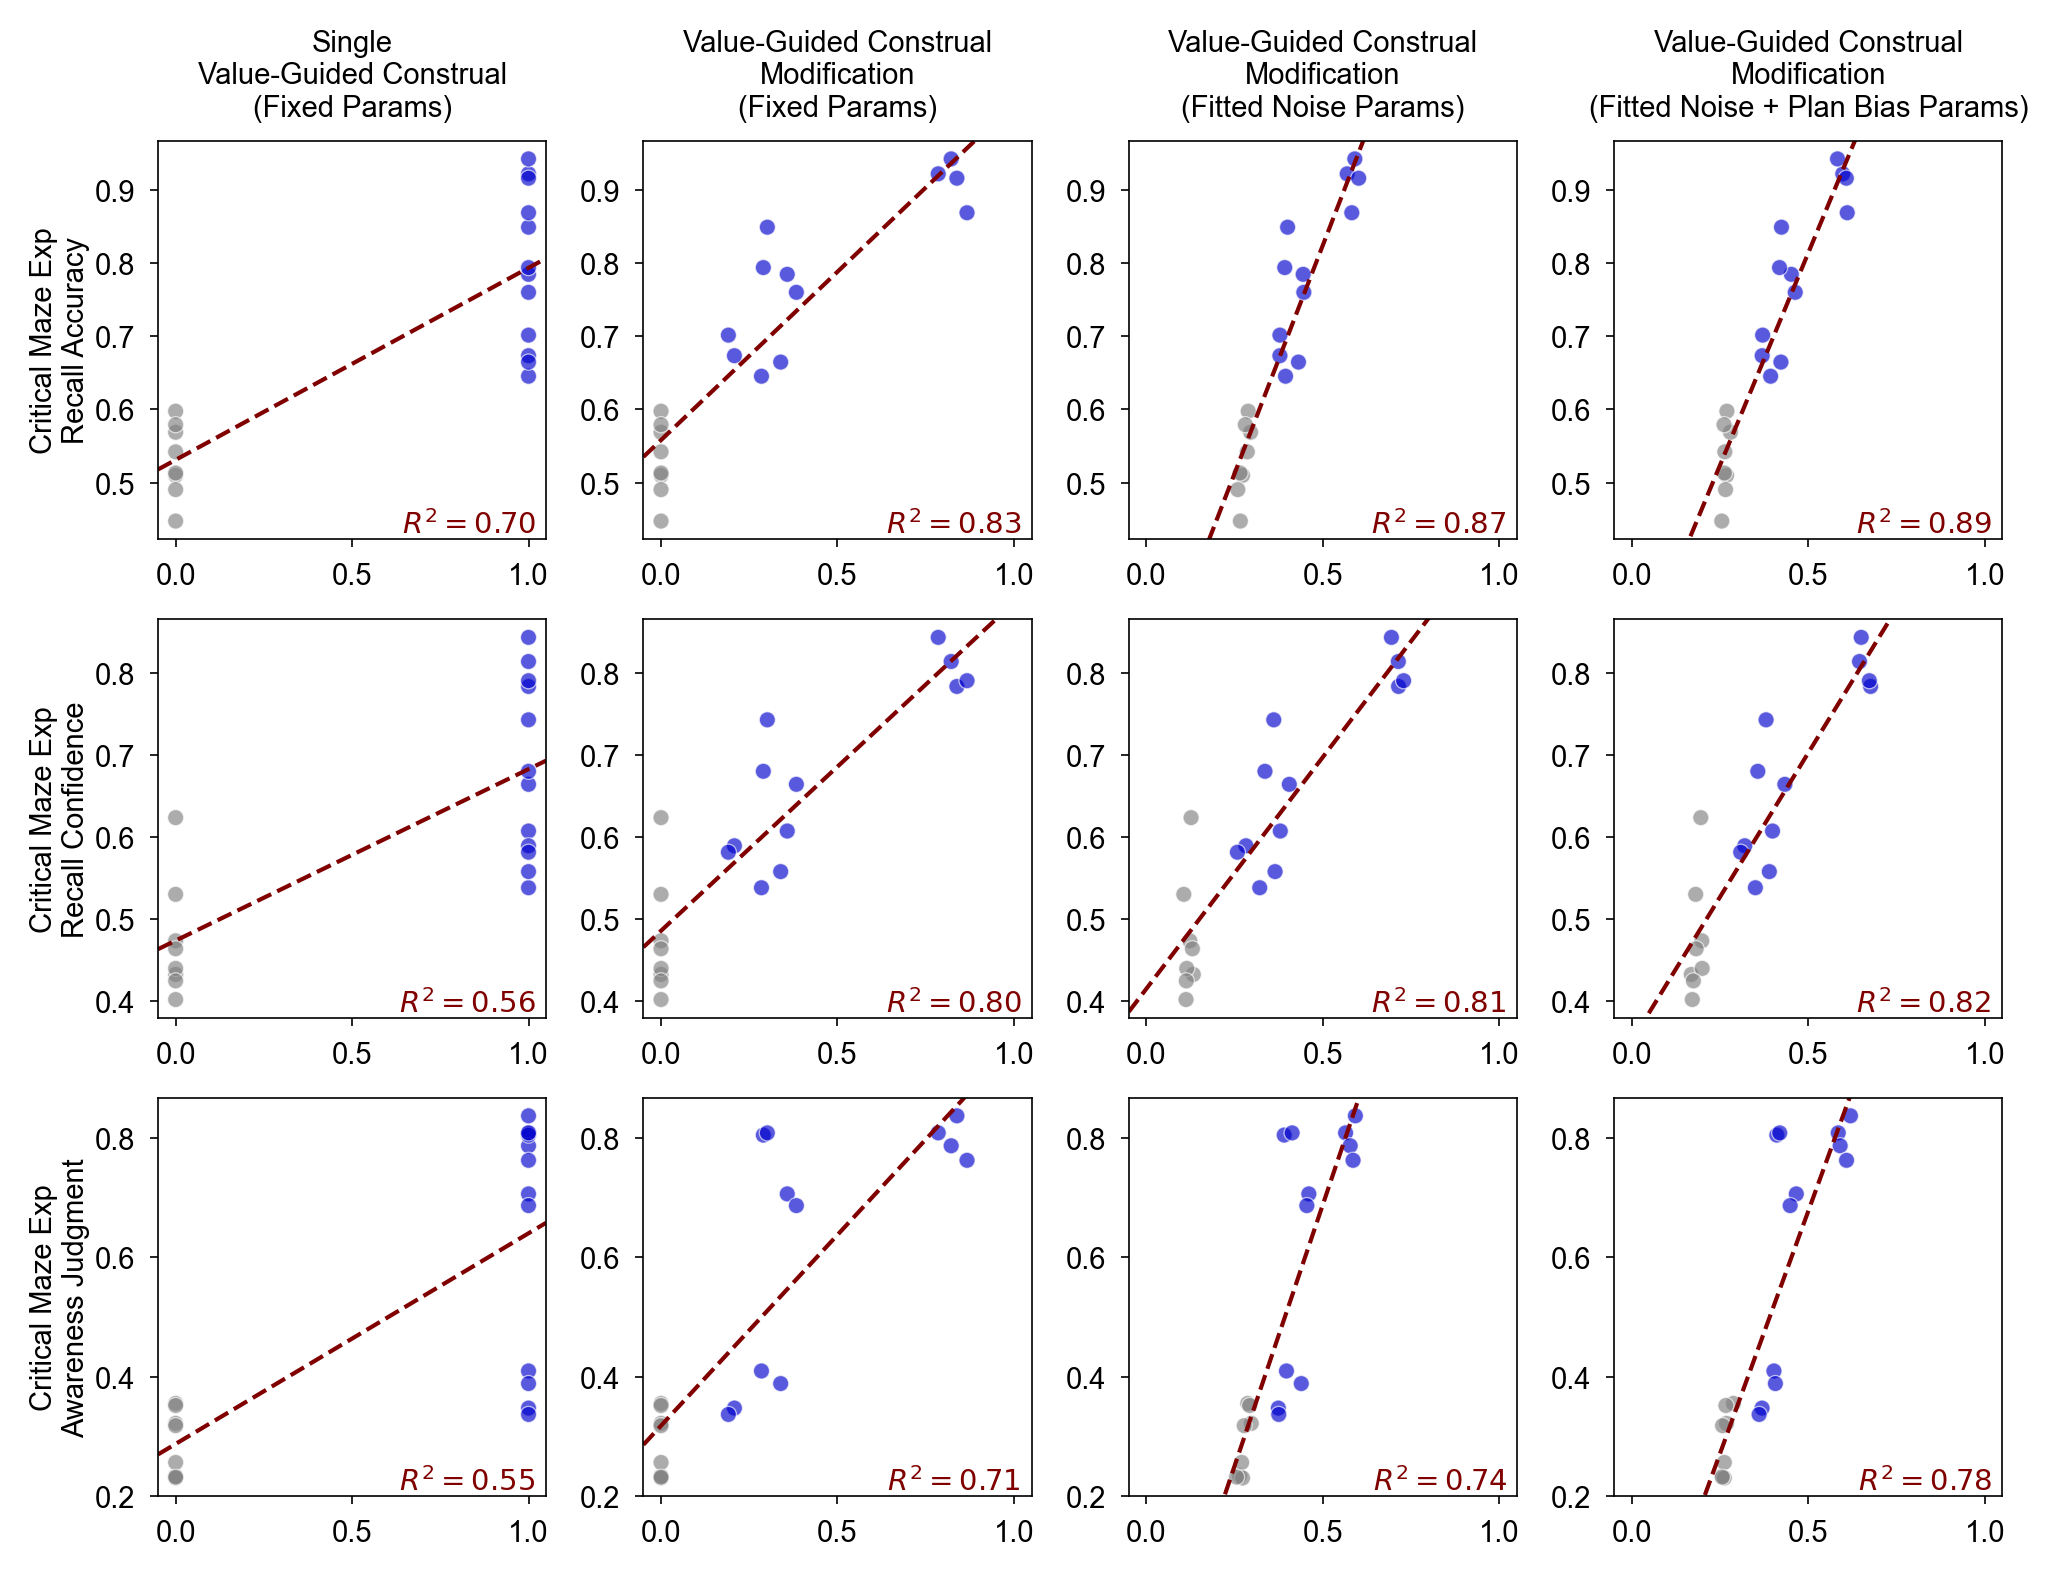

In [18]:
all_vgc_models_exp3_fig = plot_vgc_models_exp_dvs(
    exp_dvs[2:5], vgc_models, best_parameters_no_aux, best_parameters,
    figsize=(4*1.7, (3+.1)*1.7),
)
plt.tight_layout(w_pad=1, h_pad=1)
all_vgc_models_exp3_file = "./inputs/all_vgc_models_exp3.pdf"
all_vgc_models_exp3_fig.savefig(
    all_vgc_models_exp3_file,
    dpi=300,
)
print("VGC models by exp plot saved to ", all_vgc_models_exp3_file)

VGC models by exp plot saved to  ./inputs/all_vgc_models_exp4.pdf


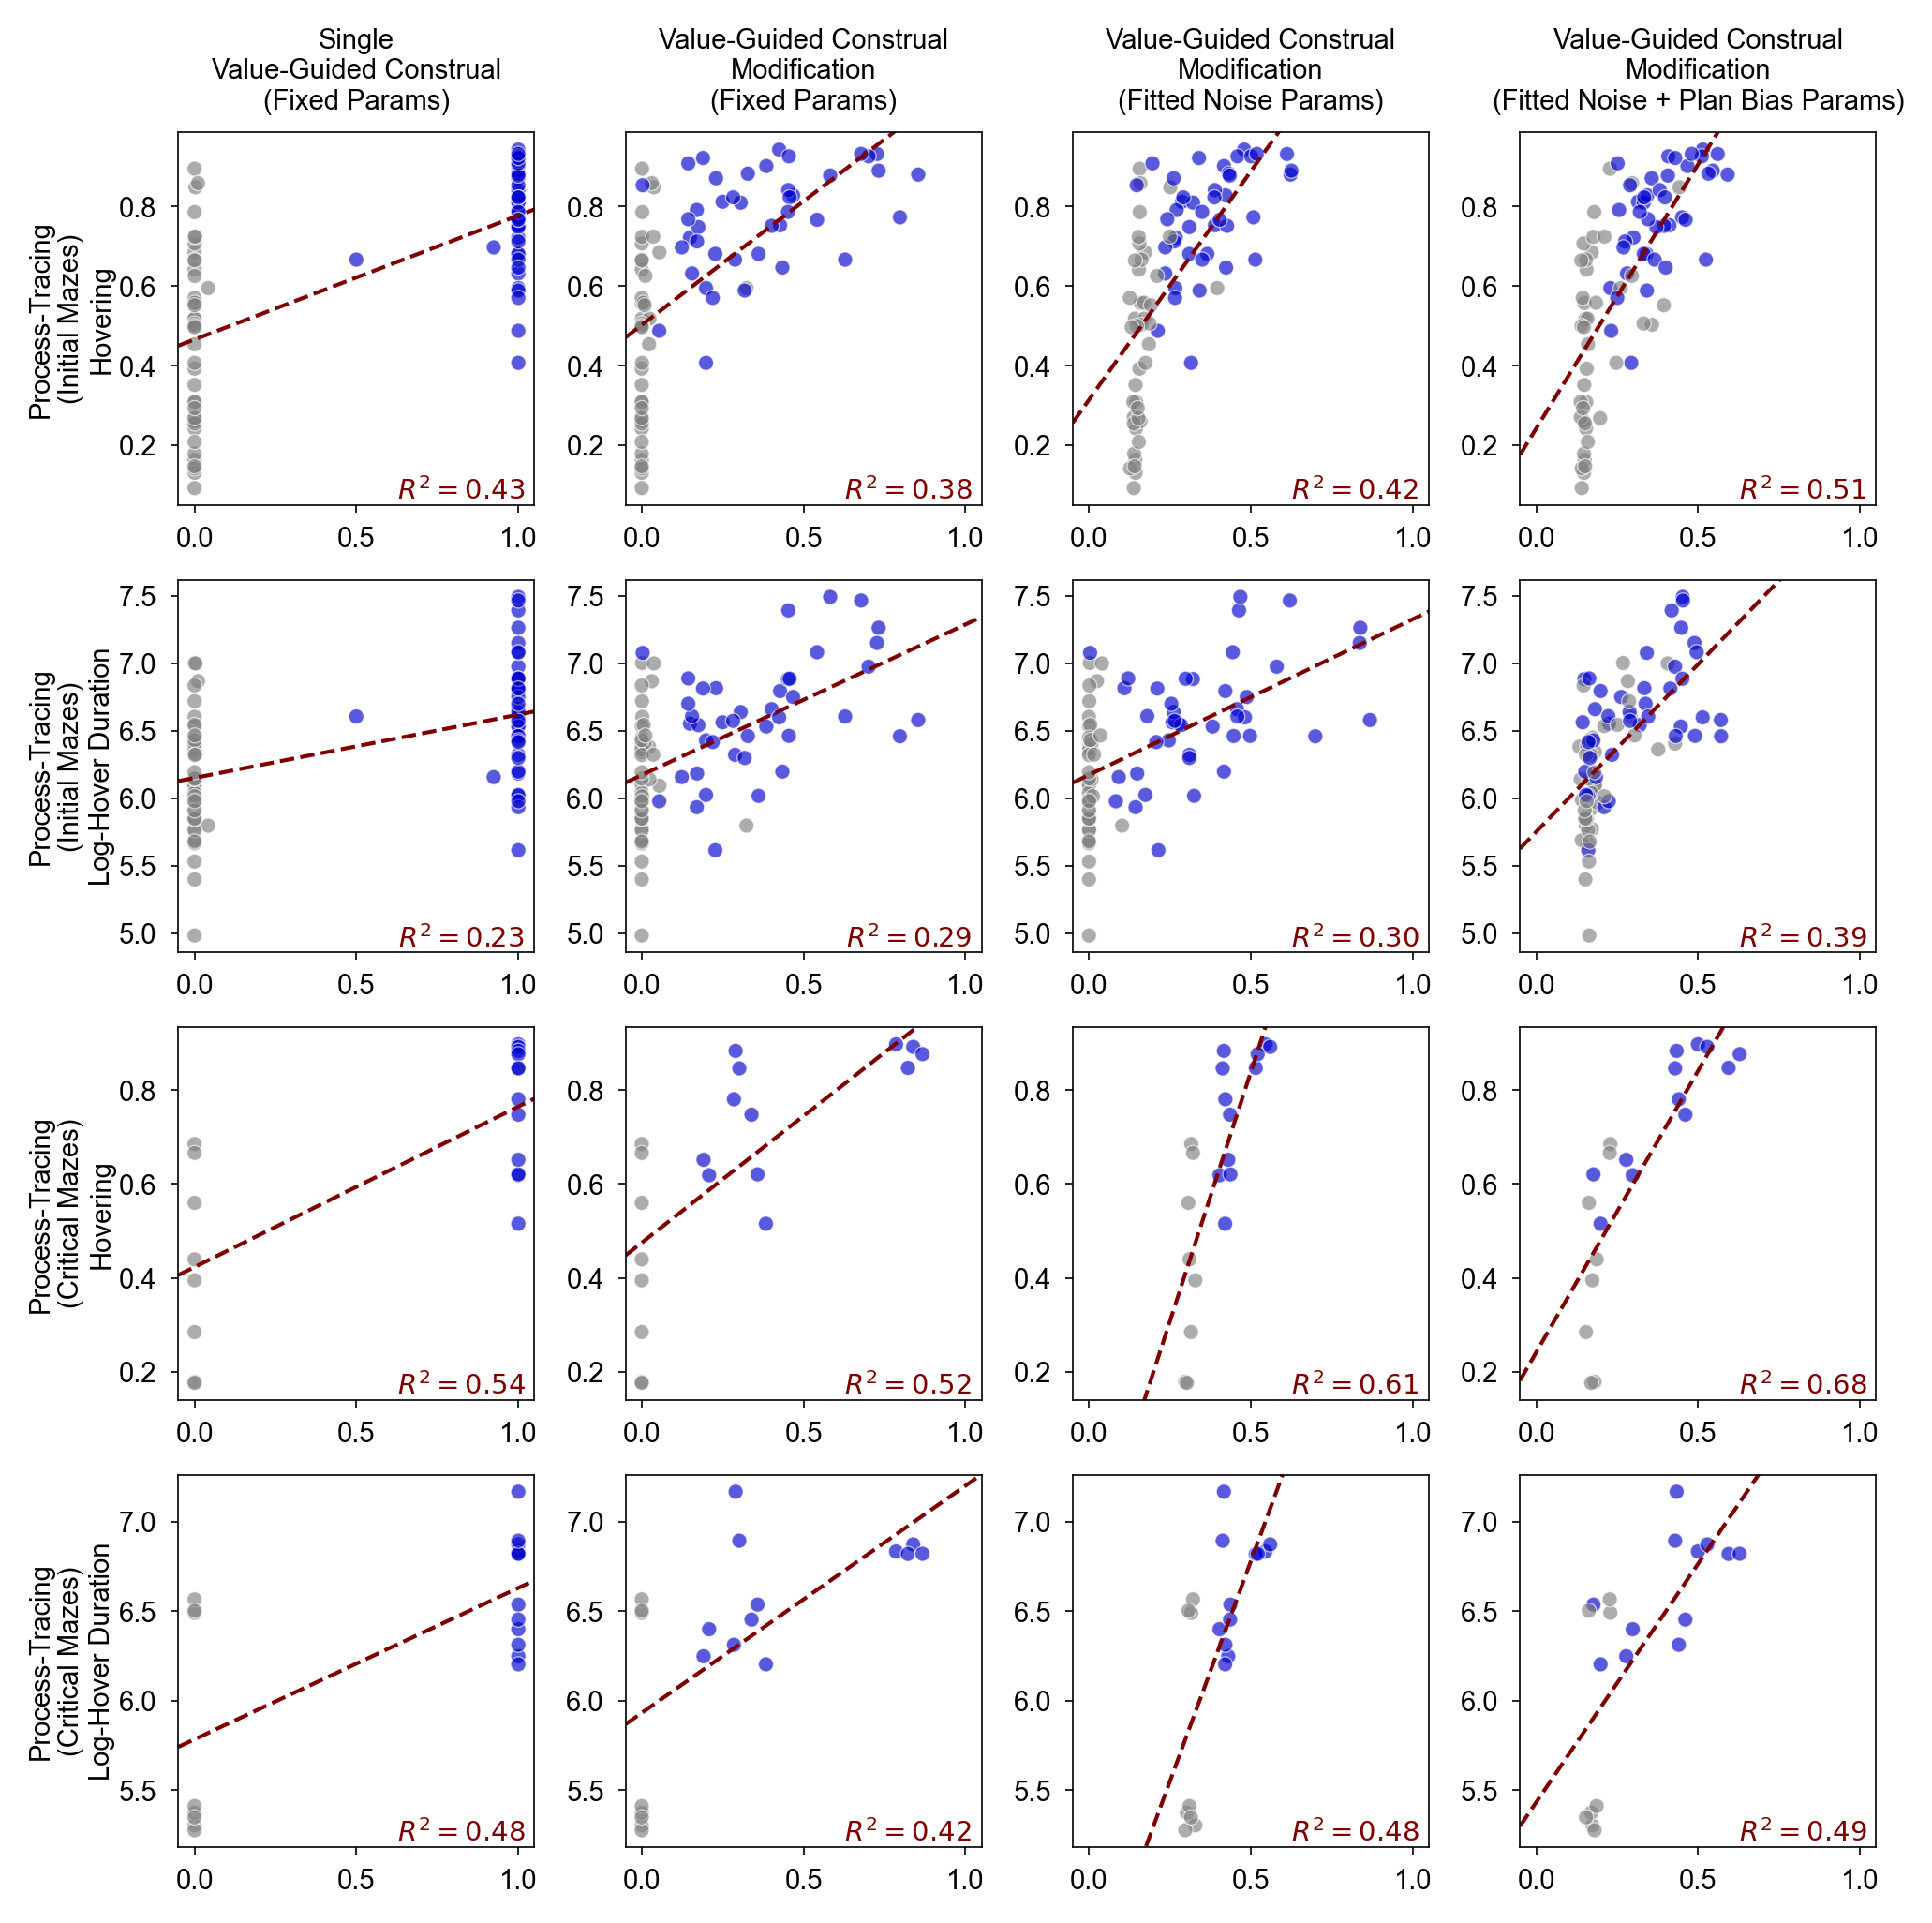

In [19]:
all_vgc_models_exp4_fig = plot_vgc_models_exp_dvs(
    exp_dvs[5:], vgc_models, best_parameters_no_aux, best_parameters,
    figsize=(4*1.7, (4+.03)*1.7),
)
plt.tight_layout(w_pad=1, h_pad=1)
all_vgc_models_exp4_file = "./inputs/all_vgc_models_exp4.pdf"
all_vgc_models_exp4_fig.savefig(
    all_vgc_models_exp4_file,
    dpi=300,
)
print("VGC models by exp plot saved to ", all_vgc_models_exp4_file)